# Diffusion Convolution PDE iterative solver

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from scipy.linalg import dft
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import numpy as np
from scipy.linalg import sqrtm

## Physical Parameters

The following parameters define the spatial and temporal discretization of the quantum heat equation:

- `x_lb = 0`: Left boundary of the spatial domain.
- `x_rb = 1`: Right boundary of the spatial domain.
- `d = 2`: Spatial dimensionality of the problem (e.g., 2D domain).
- `n = 5`: Number of discretization points per spatial dimension. The total number of grid points is \( n^d \).
- `dt = 1e-3`: Time step size used for temporal evolution. This value determines the resolution of the simulation in time and affects the stability and accuracy of the solver.

These parameters are used to construct the quantum representation of the discretized domain, which is then encoded into qubits for simulation via quantum algorithms.


In [4]:
x_lb = 0 
x_rb = 1
d = 2
n = 5
dt = 1e-3

## Spatial Grid Construction

The spatial domain is discretized into a uniform grid for numerical simulation and quantum encoding. The parameters are defined as follows:

- `N = 2**n`: Total number of grid points per spatial dimension. This exponential scaling is often used to match the number of basis states representable by \( n \) qubits, i.e., \( N = 2^n \).
- `L = x_rb - x_lb`: Physical length of the domain in one dimension.
- `dx = L / N`: Spatial resolution or grid spacing.

For a 2D simulation:
- `y_lb = x_lb`, `y_ub = x_rb`: The domain is assumed to be square.
- `N_x = N`, `N_y = N`: Number of grid points in the \( x \) and \( y \) directions.

In [6]:
N = 2**n
L = x_rb - x_lb
dx = L/N
y_lb = x_lb
y_ub = x_rb
N_y = N
N_x = N
xs, ys = np.meshgrid(np.linspace(x_lb, x_rb, N, endpoint=False), 
                    np.linspace(y_lb, y_ub, N, endpoint=False), 
                    indexing='ij')

# Heat equation
#A = jnp.eye(d)

# Diffusion with constant coefficient for d = 2
A = np.array(
    [
        [3., 1.], 
        [1., 2.]
    ]
)

## Define diffusion energy

In [8]:
import jax
import jax.numpy as jnp
@jax.vmap
@jax.vmap
def A_vec(u):
    return A@ u

@jax.vmap
@jax.vmap
def vec_dot(u, v):
    return jnp.dot(u, v)

def energy(u):

    u_h = np.fft.rfft2(u)
    wave = np.fft.fftfreq(N, d= dx) * 2j* np.pi
    wave_real = np.fft.rfftfreq(N, d= dx)* 2j* np.pi
    k_x, k_y = np.meshgrid(wave, wave_real, indexing='ij')
    u_x_h = k_x * u_h
    u_y_h = k_y * u_h
    u_vec_h = np.stack([u_x_h, u_y_h], axis=-1)
    Au_vec_h = A_vec(u_vec_h)

    return (np.mean( vec_dot(Au_vec_h, u_vec_h))/2).real

## Source Term and Initial/Final Conditions


In [10]:
def f(x, y) : 
    return np.cos(2*np.pi *x) * np.sin(-2*np.pi * y)
    

def u_init(x, y): 
    #return f(x, y)*10
    return np.cos(2*np.pi *x) * np.sin(8*np.pi *y) + 2 * np.sin(6*np.pi*y) + 3 * np.sin(10*np.pi *x) * np.cos(12 * np.pi *y)**2
    #return u_final(x, y)

## Classical Iterative Solver in Spectral Space

To simulate the time evolution of the heat equation, we implement a classical iterative solver using spectral methods. The update rule is derived from the semi-implicit time discretization of the heat equation:

$$
\frac{u^{n+1} - u^n}{\Delta t} = \mathrm{div} (A \nabla u^{n+1}) + f
$$

Rearranged as:

$$
(\mathbb{I} - \Delta t \; \mathrm{div} (A \nabla )) u^{n+1} = u^n - \Delta t f
$$

This equation is solved in Fourier space, where the Laplacian operator becomes a diagonal multiplication by \( -k^2 \). The steps are:



In [12]:
def iterative_heat(u_n, f, dt=dt): 

    u_h = np.fft.rfft2(u_n)
    f_h = np.fft.rfft2(f)

    RHS =  u_h - dt* f_h

    # Invert (\Id - dt \Delta)    
    wave = np.fft.fftfreq(N, d= dx) * 2j* np.pi
    wave_real = np.fft.rfftfreq(N, d= dx)* 2j* np.pi
    k_x, k_y = np.meshgrid(wave, wave_real, indexing='ij')
    diffuse_u_h = (A[0,0]*k_x**2 + + A[1,0] * k_x * k_y + A[0, 1] * k_y * k_x + A[1,1]*k_y**2)
    ones = np.ones_like(diffuse_u_h)
    u_next_h = RHS/(ones - dt* diffuse_u_h)
    
    return  np.fft.irfft2(u_next_h, s= (N, N))

In [13]:
"""Constructs the 1D DFT matrix of size N."""
dfmtx = np.fft.fft(np.eye(N_x))#/np.sqrt(N_x)

"""Constructs the 2D DFT matrix of size N x N as a Kronecker product."""
FG = np.kron(dfmtx, dfmtx)
GF = np.kron(
    (np.conj(dfmtx).T)/N_x, 
    (np.conj(dfmtx).T)/N_x, 
)

In [14]:
## Initialization
#u_spec = u_init(xs, ys)
#energy_spec = [energy(u_spec)]
#
#for _  in range(40):
#    u_spec = iterative_heat(u_spec, f(xs, ys), dt=dt)
#    energy_spec.append(energy(u_spec))
#
#    #u_curr = iterative_heat(u_curr, f_val, dt=dt)
#
#plt.plot(energy_spec[1:], label="energy_spec")
#plt.legend()

In [15]:
def spectral_eigenvalues(N, L=1.0):
    """Eigenvalues of the 1D derivative operator with periodic condition."""
    k = np.fft.fftfreq(N, d=L/N) * 2j * np.pi  # frequency vector
    return k  

def spectralFilter(N, dt=1e-2):
    d = spectral_eigenvalues(N)
    D= np.diag(d)
    Diffuse_h = A[0,0]*np.kron(D**2, np.eye(N)) + A[0, 1] * np.kron(D, D) + A[1, 0] * np.kron(D, D) + A[1, 1]*np.kron(np.eye(N), D**2)
    op_h = np.kron(np.eye(N), np.eye(N) ) - dt *Diffuse_h 
    #print("Condition number of D:", np.linalg.cond(op_h))
    #m_h = np.diag( 1.0/np.diag(op_h))
    #return m_h 

    return np.linalg.inv(op_h)

def iterative_heat_FG(u_val, f_val, dt): 
    N = u_val.shape[0]
    u_flatten = u_val.flatten()
    f_flatten = f_val.flatten()

    u_h = FG @ u_flatten
    f_h = FG @ f_flatten

    u_new = GF @ spectralFilter(N, dt) @ (u_h - dt * f_h)


    return u_new.reshape(N_x, N_y)



C:\Users\giaco\anaconda3\envs\qiskit-latest\Lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


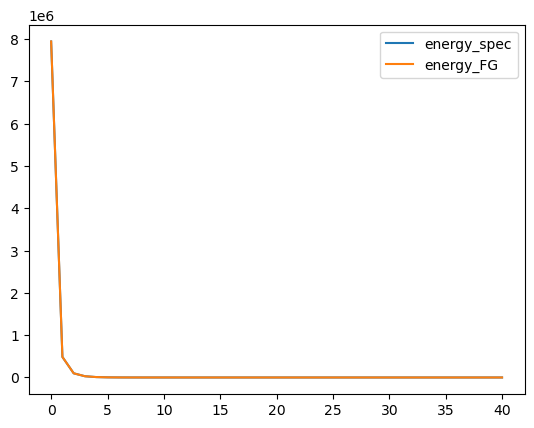

In [16]:
# Initialization
u_spec = u_init(xs, ys)
u_FG = u_init(xs,ys)
energy_spec = [energy(u_spec)]
energy_FG = [energy(u_FG)]

for _  in range(40):
    u_spec = iterative_heat(u_spec, f(xs, ys), dt=dt)
    u_FG = iterative_heat_FG(u_FG, f(xs, ys), dt=dt)
    energy_spec.append(energy(u_spec))
    energy_FG.append(energy(u_FG))

    #u_curr = iterative_heat(u_curr, f_val, dt=dt)

plt.plot(energy_spec, label="energy_spec")
plt.plot(energy_FG, label="energy_FG")
plt.legend()
#plt.savefig("diffusion_energy.png", bbox_inches="tight")

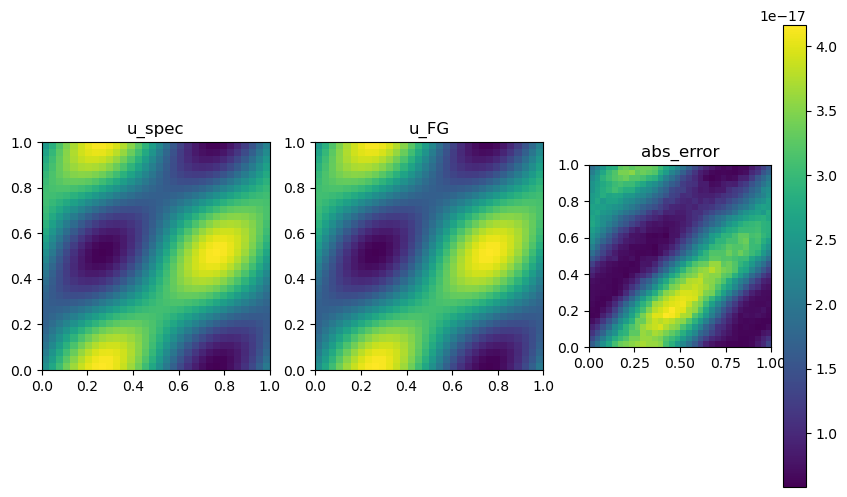

In [17]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(u_spec, extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.title("u_spec")
plt.subplot(1, 3, 2)
plt.imshow(u_FG.real, extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.title("u_FG")
plt.subplot(1, 3, 3)
plt.imshow(abs(u_spec-u_FG), extent=[x_lb, x_rb, y_lb, y_ub], origin='lower')
plt.title("abs_error")
plt.colorbar()